# Setting up the environment

In [ ]:
!pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from tqdm import tqdm
from tensorflow.keras import layers
import tensorflow_addons as tfa
from google.colab.patches import cv2_imshow
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [ ]:
!nvidia-smi

Sun May  2 10:56:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Extract dataset

In [ ]:
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/trainDown.zip' 
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/trainLeft.zip' 
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/trainRight.zip' 
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/trainUp.zip' 
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/trainstop.zip' 


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/Computer . nition/MFF dataset/New Dataset/                                                                           1 file, 815922367 bytes (779 MiB)

Extracting archive: /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/trainDown.zip
  6% 4096 Open               43% 28672 Open               --
Path = /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/trainDown.zip
Type = zip
Physical Size = 815922367
64-bit = +

  0%      0% 1991 - t

In [ ]:
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/valDown.zip' 
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/valLeft.zip' 
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/valRight.zip' 
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/valUp.zip' 
!7z x '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/valstop.zip' 


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/Computer . nition/MFF dataset/New Dataset/                                                                           1 file, 102957092 bytes (99 MiB)

Extracting archive: /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/valDown.zip
 13% 4096 Open               40% 12288 Open               --
Path = /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF dataset/New Dataset/valDown.zip
Type = zip
Physical Size = 102957092

  0%      5% 1923 - valDown/flow/u/12

In [ ]:
!mkdir '/content/dataset'



!mv '/content/trainstop' '/content/dataset'
!mv '/content/trainRight' '/content/dataset'
!mv '/content/trainLeft' '/content/dataset'
!mv '/content/trainDown' '/content/dataset'
!mv '/content/trainUp' '/content/dataset'



!mv '/content/valstop' '/content/dataset'
!mv '/content/valLeft' '/content/dataset'
!mv '/content/valRight' '/content/dataset'
!mv '/content/valDown' '/content/dataset'
!mv '/content/valUp' '/content/dataset'

# Working with dataset

## Reading CSVs

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-train.csv', delimiter=';', header=None)
df_test = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-test.csv', delimiter=';', header=None)
df_val = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-validation.csv', delimiter=';', header=None)
df_labels = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-labels.csv', delimiter=';', header=None)

selected_gestures = set(['Swiping Left', 'Swiping Right', 'Swiping Down', 'Swiping Up', 'Stop Sign'])

train_csv = df_train.to_dict(orient='split')['data']
train_dataset = {selected_label : [] for selected_label in selected_gestures}
for data in train_csv:
    if data[1] in selected_gestures:
        train_dataset[data[1]].append(data[0])

validation_csv = df_val.to_dict(orient='split')['data']
val_data = {selected_label : [] for selected_label in selected_gestures}
for data in validation_csv:
    if data[1] in selected_gestures:
        val_data[data[1]].append(data[0])

## Extracting Training and Validation Data

In [ ]:
dataset_dir = '/content/dataset'
all_classes = sorted(os.listdir(dataset_dir))
#all_classes.remove('.ipynb_checkpoints')
all_classes

['trainDown',
 'trainLeft',
 'trainRight',
 'trainUp',
 'trainstop',
 'valDown',
 'valLeft',
 'valRight',
 'valUp',
 'valstop']

In [ ]:
dataset_dir = '/content/dataset'
all_classes = sorted(os.listdir(dataset_dir))
#all_classes.remove('.ipynb_checkpoints')
train_rgb_images = [] 
train_v_images = []
train_u_images = []
val_rgb_images = [] 
val_v_images = []
val_u_images = []
for gesture in all_classes:
    gesture_dir = os.path.join(dataset_dir, gesture)
    flow_u_dir = os.path.join(gesture_dir, 'flow/u')
    flow_v_dir = os.path.join(gesture_dir, 'flow/v')
    rgb_dir = os.path.join(gesture_dir, 'rgb')
    
    if gesture.startswith('train'):
        
        train_rgb_images.extend([os.path.join(rgb_dir, image_path) 
                            for image_path in os.listdir(rgb_dir)])
        
        train_v_images.extend([os.path.join(flow_v_dir, image_path) 
                            for image_path in os.listdir(flow_v_dir)])
        
        train_u_images.extend([os.path.join(flow_u_dir, image_path) 
                            for image_path in os.listdir(flow_u_dir)])
    
    else:

        val_rgb_images.extend([os.path.join(rgb_dir, image_path) 
                            for image_path in os.listdir(rgb_dir)])
        
        val_v_images.extend([os.path.join(flow_v_dir, image_path) 
                            for image_path in os.listdir(flow_v_dir)])
        
        val_u_images.extend([os.path.join(flow_u_dir, image_path) 
                            for image_path in os.listdir(flow_u_dir)])

In [ ]:
gesture_dir_names = all_classes

tfrecords_dir = os.path.join(dataset_dir, 'tfrecords')
train_size = len(train_rgb_images)
val_size = len(val_rgb_images)
images_per_file = 125 

train_image_paths = list(zip(train_rgb_images, train_u_images, train_v_images))
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, 'train')

val_image_paths = list(zip(val_rgb_images, val_u_images, val_v_images))
num_val_files = int(np.ceil(val_size / images_per_file))
val_files_prefix = os.path.join(tfrecords_dir, 'val')

In [ ]:
def show_example(example):
    for i in range(0, 8*9, 9):
        print(i, i+3)
        img = example[:, : , i : i+3]
        cv2_imshow(img)
        for j in range(i+3, i+9):
            print(j)
            cv2_imshow(example[:, : , j])

def show_segment(segment):
    print("0 - 3")
    img = segment[:, : , 0 : 3]
    cv2_imshow(img)
    for j in range(3, 9):
        print(j)
        cv2_imshow(segment[:, : , j])

def show_segments(segments):
    for i in range(8):
        print(i)
        print('*' * 70)
        show_segment(segments[i])

In [ ]:
def read_data(path):
    '''
    path :- [
             <a rgb_dir path with 8 rgb images>,
             <a flow_u dir path with 24 frames>,
             <a flow_v dir path with 24 frames>
            ]
    
    should return : image, label
    
    Image should have 8 segments, each segment should have
    3 rgb channels and 3*2 : flow_u, flow_v channels

    '''
    
    example = np.zeros((100, 176, 72))
    img_dir, flow_u_dir, flow_v_dir = path
    imgs = sorted([os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]) 
    flow_us = sorted([os.path.join(flow_u_dir, img_name) for img_name in os.listdir(flow_u_dir)])   
    flow_vs = sorted([os.path.join(flow_v_dir, img_name) for img_name in os.listdir(flow_v_dir)])

    for i in range(8):
        img = cv2.imread(imgs[i]) 
        flow_channels = [
                    (cv2.imread(flow_us[j], 0),
                    cv2.imread(flow_vs[j], 0))
                    for j in range(i*3, i*3+3)
                    ]
            
        try:
            example[:, : , i*9 : i*9+3] = img

        except: 
            img = cv2.resize(img, (176, 100))
            example[:, : , i*9 : i*9+3] = img

        for j in range(0, 6, 2):
            try:
                example[..., i*9 +3 + j] = flow_channels[j//2][0]
                example[..., i*9 +3 + j + 1] = flow_channels[j//2][1]
            
            except:
                example[..., i*9 +3 + j] = cv2.resize(flow_channels[j//2][0], (176, 100))
                example[..., i*9 +3 + j + 1] = cv2.resize(flow_channels[j//2][1], (176, 100))
                
    label = gesture_dir_names.index(img_dir[17:img_dir.index('/', 17)])
    return (example, label)

0 3


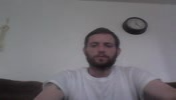

3


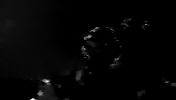

4


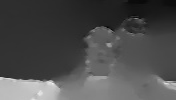

5


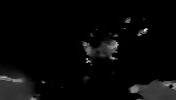

6


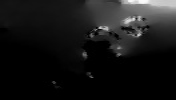

7


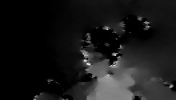

8


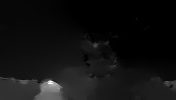

9 12


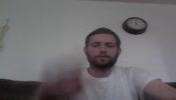

12


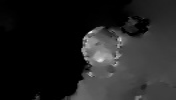

13


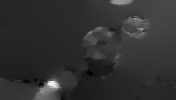

14


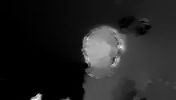

15


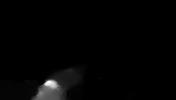

16


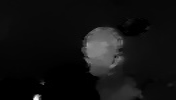

17


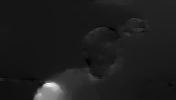

18 21


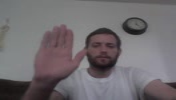

21


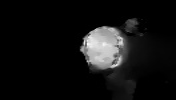

22


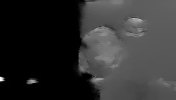

23


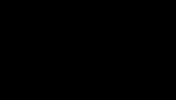

24


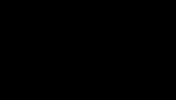

25


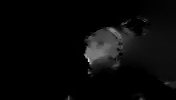

26


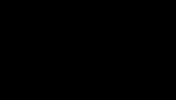

27 30


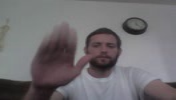

30


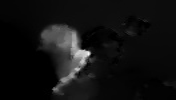

31


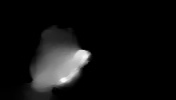

32


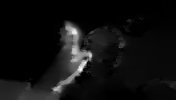

33


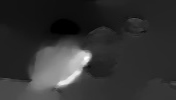

34


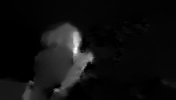

35


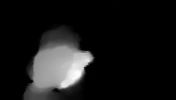

36 39


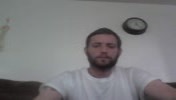

39


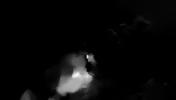

40


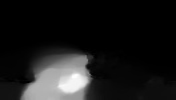

41


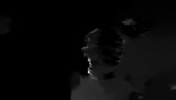

42


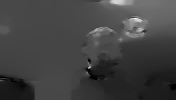

43


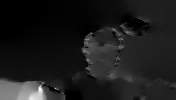

44


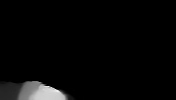

45 48


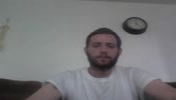

48


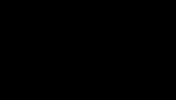

49


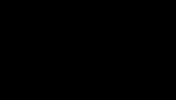

50


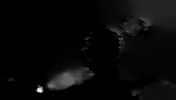

51


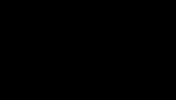

52


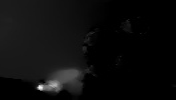

53


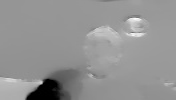

54 57


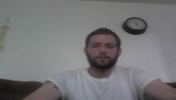

57


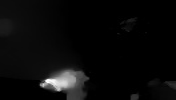

58


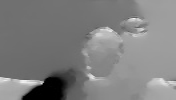

59


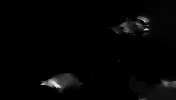

60


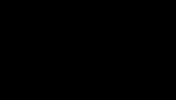

61


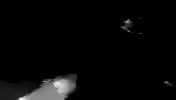

62


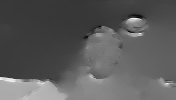

63 66


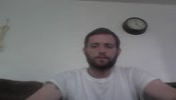

66


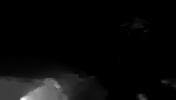

67


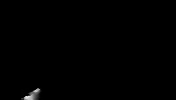

68


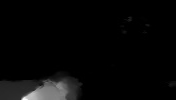

69


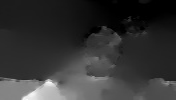

70


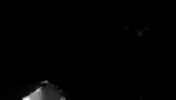

71


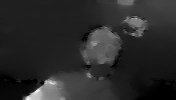

In [ ]:
example, label = read_data(train_image_paths[0])
show_example(example)

##  Tfrecords --> Dont Run This Block

In [ ]:
tf.io.gfile.makedirs(tfrecords_dir)

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    return tf.io.serialize_tensor(array)

def create_example(path):
    example, label = read_data(path)
    feature = {
        'label' : _int64_feature(label),
        'segment_1' : _bytes_feature(serialize_array(example[0:9])),
        'segment_2' : _bytes_feature(serialize_array(example[9:18])),
        'segment_3' : _bytes_feature(serialize_array(example[18:27])),
        'segment_4' : _bytes_feature(serialize_array(example[27:36])),
        'segment_5' : _bytes_feature(serialize_array(example[36:45])),
        'segment_6' : _bytes_feature(serialize_array(example[45:54])),
        'segment_7' : _bytes_feature(serialize_array(example[54:63])),
        'segment_8' : _bytes_feature(serialize_array(example[63:72])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
def write_tfrecords(file_name, image_paths):
    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_paths)):
            example = create_example(image_paths[example_idx])
            writer.write(example.SerializeToString())
    return example_idx + 1

In [ ]:
def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter

In [ ]:
train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)

In [ ]:
val_example_count = write_data(val_image_paths, num_val_files, val_files_prefix)

In [ ]:
!rm -r /content/dataset/tfrecords

## tf.data.Dataset

In [ ]:
def extract_segments_and_label(path):
    '''
    path :- [
             <a rgb_dir path with 8 rgb images>,
             <a flow_u dir path with 24 frames>,
             <a flow_v dir path with 24 frames>
            ]
    
    should return : Segments, label
    
    Segments should be a list of 8 segments, each segment should have
    3 rgb channels and 3*2 : flow_u, flow_v channels

    '''
    
    Segments = []
    img_dir, flow_u_dir, flow_v_dir = path
    imgs = sorted([os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]) 
    flow_us = sorted([os.path.join(flow_u_dir, img_name) for img_name in os.listdir(flow_u_dir)])   
    flow_vs = sorted([os.path.join(flow_v_dir, img_name) for img_name in os.listdir(flow_v_dir)])

    for i in range(8):
        segment = np.zeros((100, 176, 9))
        
        img = cv2.imread(imgs[i]) 
        #cv2_imshow(img)
        flow_channels = [
                    (cv2.imread(flow_us[j], 0),
                    cv2.imread(flow_vs[j], 0))
                    for j in range(i*3, i*3+3)
                    ]
        
        try:
            segment[:, : , 0 : 3] = img

        except: 
            img = cv2.resize(img, (176, 100))
            segment[:, : , 0 : 3] = img

        for j in range(0, 6, 2):
            
            try:
                
                segment[..., 3 + j] = flow_channels[j//2][0]
                segment[..., 3 + j + 1] = flow_channels[j//2][1]
            
            except:
                segment[..., 3 + j] = cv2.resize(flow_channels[j//2][0], (176, 100))
                segment[..., 3 + j + 1] = cv2.resize(flow_channels[j//2][1], (176, 100))

        Segments.append(segment) 
        
    label = gesture_dir_names.index(img_dir[17:img_dir.index('/', 17)])
    if label >= 5: label -=5
    label = tf.one_hot(label, depth = 5)
    return (Segments, label)

In [ ]:
gesture_dir_names

['trainDown',
 'trainLeft',
 'trainRight',
 'trainUp',
 'trainstop',
 'valDown',
 'valLeft',
 'valRight',
 'valUp',
 'valstop']

In [ ]:
segments, label = extract_segments_and_label(val_image_paths[2])
show_segments(segments)
print(label)

In [ ]:
def extract_data(paths):
    def f(paths):
        paths = [paths[i].decode() for i in range(len(paths))]
        return extract_segments_and_label(paths) 
    return tf.numpy_function(f, [paths], [tf.float64, tf.float32])

In [ ]:
batch_size = 8

In [ ]:
train_image_paths = shuffle(train_image_paths)
train_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
train_ds = train_ds.map(extract_data)
train_ds = train_ds.shuffle(buffer_size=10)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(3)

In [ ]:
val_image_paths = shuffle(val_image_paths)
val_ds = tf.data.Dataset.from_tensor_slices(val_image_paths)
val_ds = val_ds.map(extract_data)
val_ds = val_ds.shuffle(buffer_size=10)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(3) 

#Gesture Model v2

## Design Gesture Model

In [ ]:
num_projection_layers=1
projection_dims=512
dropout_rate=0.1
unresized_segment_shape = (100, 176, 3)
segment_shape = (224, 224, 3)

In [ ]:
inputs = tf.keras.layers.Input(shape = (segment_shape[0], segment_shape[1], 9), name = 'segment_input')
Inputs = tf.keras.layers.Input(shape = (segment_shape[0], segment_shape[1], 3), name = 'segments_input')

In [ ]:
model = create_reduce_channels_model()
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
def project_embeddings_block(embeddings, num_projection_layers, projection_dims, dropout_rate):
    embeddings = layers.GlobalAvgPool2D()(embeddings)
    projected_embeddings = layers.Dense(units = projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [ ]:
def encoder_block(cnn_encoder, inputs):
    embeddings = encoder(inputs)
    outputs = project_embeddings_block(embeddings, num_projection_layers, projection_dims, dropout_rate)
    return outputs

In [ ]:
for x, y in train_ds:
    a = x
    break

In [ ]:
b = tf.unstack(a, axis = 1)
for t in b:
    print(t.shape)

In [ ]:
def call(self, segments, training = False):
        with tf.device("/gpu:0"):
            concat = []
            for i in range(8):
                segment = segments[:, i, :, :, :]
                embeddings = resize_and_rescale(segment)
                embeddings = reduce_channels(embeddings)
                embeddings = cnn_encoder(embeddings, training = training)
                
                concat.append(embeddings)

            concat = tf.concat(concat, axis = -1)
            x = layers.Dense(2048, activation='relu')(concat)
            x = layers.Dropout(0.2)(x)
            x = layers.Dense(512, activation='relu')(x)
            x = layers.Dropout(0.2)(x)
            pred = layers.Dense(5, activation='softmax')(x)
            return pred

In [ ]:
class Gesture_Model(tf.keras.Model):
    def __init__(self, cnn_encoder, project_embeddings_block, reduce_channels_block, resize_and_rescale, fcn_block, batch_size,  **kwargs):
        super(Gesture_Model, self).__init__(**kwargs)
        
        self.resize_and_rescale = resize_and_rescale
        self.reduce_channels_block = reduce_channels_block
        self.cnn_encoder = cnn_encoder
        self.project_embeddings_block = project_embeddings_block
        self.fcn_block = fcn_block
        self.loss_tracker = tf.keras.metrics.Mean(name = 'loss')
        self.accuracy_tracker = tf.keras.metrics.CategoricalAccuracy(name = 'accuracy')
        self.batch_size = batch_size
        
    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def call(self, segments, training = False):
       with tf.device("/gpu:0"):
            concat = []
            for i in range(8):

                segment = segments[:, i, :, :, :]
                inputs = layers.Input(tensor = segment)
                
                embeddings = self.resize_and_rescale(segment)

                embeddings = self.reduce_channels_block(embeddings)
                
                embeddings = self.cnn_encoder(embeddings)
                embeddings = self.project_embeddings_block(embeddings, num_projection_layers, projection_dims, dropout_rate)
                concat.append(embeddings)

            concat = tf.stack(concat, axis = 1)
            concat = tf.reshape(concat, shape = (self.batch_size, -1))
            return self.fcn_block(concat)          
            
    def compute_loss(self, y_true, pred):
        return tf.keras.losses.categorical_crossentropy(y_true, pred)

    def train_step(self, data):
        segments, y_true = data
        with tf.GradientTape() as tape:
            
            pred = self(segments, training = True)
            loss = tf.keras.losses.categorical_crossentropy(y_true, pred)


        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y_true, pred)
        return {'loss' : self.loss_tracker.result(), 'accuracy' : self.accuracy_tracker.result()}

    def test_step(self, data):
        segments, y_true = data
        pred = self(segments, training = False)
        loss = tf.keras.losses.categorical_crossentropy(y_true, pred)
        self.loss_tracker.update_state(loss)
        return {'loss' : self.loss_tracker.result(), 'accuracy' : self.accuracy_tracker.result()}

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(segment_shape[0], segment_shape[1]),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
def create_reduce_channels_model():
    segments = layers.Input(shape = (8, 100, 176, 9))
    
    x = layers.Conv3D(16, kernel_size=(3,3,3), activation = 'gelu', padding = 'same')(segments)
    x = layers.Conv3D(8, kernel_size=(3,3,3), activation = 'gelu', padding = 'same')(x)
    x = layers.Conv3D(4, (3,3,3), activation='gelu', padding='same')(x)
    x = layers.Conv3D(3, (3,3,3), activation='gelu', padding='same')(x)

    return tf.keras.Model(inputs = segments, outputs = x, name = 'reduce_dims_model')

In [ ]:
def create_cnn_model(cnn_encoder, project_embeddings_block, 
                         reduce_channels_block, resize_and_rescale, segment_shape):
    
    segment = layers.Input(shape = segment_shape)
    embeddings = resize_and_rescale(segment)              
    embeddings = cnn_encoder(embeddings)
    outputs = project_embeddings_block(embeddings, num_projection_layers, projection_dims, dropout_rate)
    
    return tf.keras.Model(inputs = segment, outputs = outputs, name = 'cnn_model')
    


In [ ]:
def create_fcn_model(cnn_output_shape):
    inputs = layers.Input(shape = cnn_output_shape)
    x = layers.Dense(2048, activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    pred = layers.Dense(5, activation='softmax')(x)
    return tf.keras.Model(inputs = inputs, outputs = pred, name = 'fcn_model')

In [ ]:
class Gesture_Model(tf.keras.Model):
    def __init__(self, reduce_dims_model, cnn_model, fcn_model, batch_size, **kwargs):
        super(Gesture_Model, self).__init__(**kwargs)
        
        self.cnn_model = cnn_model
        self.fcn_model = fcn_model
        self.reduce_dims_model = reduce_dims_model
        self.loss_tracker = tf.keras.metrics.Mean(name = 'loss')
        self.accuracy_tracker = tf.keras.metrics.CategoricalAccuracy(name = 'accuracy')
        self.batch_size = batch_size
        
    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def call(self, segments, training = False):
       with tf.device("/gpu:0"):

            segments = reduce_dims_model(segments, training = training)

            concat = []
            for i in range(8):

                segment = segments[:, i, :, :, :]
                embeddings = cnn_model(segment, training = training)
                concat.append(embeddings)

            concat = tf.stack(concat, axis = 1)
            concat = tf.reshape(concat, shape = (-1, projected_dims * 8))
            pred = fcn_model(concat, training = training)
            return pred          
            
    def compute_loss(self, y_true, pred):
        return tf.keras.losses.categorical_crossentropy(y_true, pred)

    def train_step(self, data):
        segments, y_true = data
        with tf.GradientTape() as tape:
            
            pred = self(segments, training = True)
            loss = self.compute_loss(y_true, pred)


        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y_true, pred)
        return {'loss' : self.loss_tracker.result(), 'accuracy' : self.accuracy_tracker.result()}

    def test_step(self, data):
        segments, y_true = data
        pred = self(segments, training = False)
        loss = self.compute_loss(y_true, pred)
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y_true, pred)
        return {'loss' : self.loss_tracker.result(), 'accuracy' : self.accuracy_tracker.result()}

## Create Gesture model

In [ ]:
cnn_encoder = tf.keras.applications.InceptionV3(include_top=False, input_shape=(segment_shape[0], segment_shape[1], 3))
cnn_encoder.trainable = True
cnn_output_shape = cnn_encoder.output_shape[1:]


In [ ]:
reduce_dims_model = create_reduce_channels_model()
cnn_model = create_cnn_model(cnn_encoder, project_embeddings_block, 
                             reduce_channels_block, resize_and_rescale,
                             unresized_segment_shape)
fcn_model = create_fcn_model(projection_dims*8)


In [ ]:
tf.keras.utils.plot_model(reduce_dims_model, show_shapes = True, expand_nested = False)

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True, expand_nested=False)

In [ ]:
tf.keras.utils.plot_model(fcn_model, show_shapes = True, expand_nested=True)

In [ ]:
Gesture_model = Gesture_Model(cnn_encoder, project_embeddings_block, reduce_channels_block, resize_and_rescale, fcn_block, batch_size) 

In [ ]:
Gesture_model = Gesture_Model(reduce_dims_model, cnn_model, fcn_model, batch_size)
Gesture_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [ ]:
for data in val_ds:
    print(data[0].shape)
    #print(data[1])
    pred = Gesture_model.test_step(data)
    print(pred)
    break

(64, 8, 100, 176, 9)
{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.2326827>, 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.140625>}


In [ ]:
gesture_model.summary()

Model: "gesture__model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_model (Functional)       (None, 512)               23115552  
_________________________________________________________________
fcn_model (Functional)       (None, 5)                 10493957  
_________________________________________________________________
reduce_dims_model (Functiona (None, 8, 100, 176, 3)    8563      
Total params: 33,618,076
Trainable params: 33,583,640
Non-trainable params: 34,436
_________________________________________________________________


In [ ]:
reduce_channels = reduce_channels(inputs):
    project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate):
    encoder(cnn_encoder, inputs):
    fcn(inputs):()

cnn_encoder = create_encoder()

Gesture_model = Gesture_Model(encoder, reduce_channels, resize_and_rescale, batch_size)

Gesture_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [ ]:
Gesture_model.summary()

Model: "gesture__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_encoder (Functional)     (None, 512)               48281376  
_________________________________________________________________
reduce_channels (Functional) (None, 224, 224, 3)       1324      
Total params: 48,282,704
Trainable params: 48,248,268
Non-trainable params: 34,436
_________________________________________________________________


##Training Model

In [ ]:
batch_size = 8

In [ ]:
extra_train = len(train_image_paths) % batch_size
extra_val = len(val_image_paths) % batch_size
extra_train, extra_val

(6, 0)

In [ ]:
train_image_paths = shuffle(train_image_paths)
train_ds = tf.data.Dataset.from_tensor_slices(train_image_paths[:-extra_train])
train_ds = train_ds.map(extract_data)
train_ds = train_ds.shuffle(buffer_size=10)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(3)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
val_image_paths = shuffle(val_image_paths)
val_ds = tf.data.Dataset.from_tensor_slices(val_image_paths[:-extra_val])
val_ds = val_ds.map(extract_data)
val_ds = val_ds.shuffle(buffer_size=10)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(3) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
for x, y in train_ds:
    print(x.shape)

In [ ]:
num_epochs = 5
reduce_channels = create_reduce_channels_encoder()

cnn_encoder = create_encoder()

Gesture_model = Gesture_Model(cnn_encoder, reduce_channels, resize_and_rescale, batch_size)

Gesture_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001),
    metrics = ['accuracy']
)

In [ ]:
num_epochs = 5

cnn_encoder = tf.keras.applications.InceptionV3(include_top=False, input_shape=(segment_shape[0], segment_shape[1], 3))
cnn_encoder.trainable = True
cnn_output_shape = cnn_encoder.output_shape[1:]

reduce_dims_model = create_reduce_channels_model()
cnn_model = create_cnn_model(cnn_encoder, project_embeddings_block, 
                             reduce_channels_block, resize_and_rescale,
                             unresized_segment_shape)
fcn_model = create_fcn_model(projection_dims*8)

Gesture_model = Gesture_Model(reduce_dims_model, cnn_model, fcn_model, batch_size)
Gesture_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [ ]:
for x, y in train_ds:
    print(x.shape)
    print(y)
    pred = Gesture_model(x)
    print(pred)
    break

In [ ]:
#Gesture_model.load_weights(filepath='/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF_Models/Gesture_model_v1.h5')

In [ ]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of Videos): {len(train_ds) * 8}")
print(f"Batch size: {batch_size}")

# Create a learning rate scheduler callback.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF_Models/Gesture_model_v2.h5', monitor = 'val_loss', verbose = 1, save_weights_only = True, save_best_only = True
)
tf.config.run_functions_eagerly(True)
history = Gesture_model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
)

### plotting history

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
 plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
accuracy = tf.keras.metrics.CategoricalAccuracy()
for data in val_ds:
    pred = Gesture_model(data[0])
    accuracy.update_state(data[1], pred)
accuracy.result().numpy()
    

0.20125785

In [ ]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state([0, 0, 1], [0.1, 0.5, 0.51])
m.result().numpy()

1.0

In [ ]:
Gesture_model.evaluate(data[0], data[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


2/2 [==============================] - 2s 825ms/step - loss: 1.6061


1.6061344146728516

#Gesture Model v3

## Extract data

In [ ]:
resized_shape = (224, 224)

In [ ]:
def extract_segments_and_label(path):
    '''
    path :- [
             <a rgb_dir path with 8 rgb images>,
             <a flow_u dir path with 24 frames>,
             <a flow_v dir path with 24 frames>
            ]
    
    should return : Segments, label
    
    Segments should be a list of 8 segments, each segment should have
    3 rgb channels and 3*2 : flow_u, flow_v channels

    '''
    
    Segments = []
    img_dir, flow_u_dir, flow_v_dir = path
    imgs = sorted([os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]) 
    flow_us = sorted([os.path.join(flow_u_dir, img_name) for img_name in os.listdir(flow_u_dir)])   
    flow_vs = sorted([os.path.join(flow_v_dir, img_name) for img_name in os.listdir(flow_v_dir)])

    for i in range(8):
        segment = np.zeros((resized_shape[0], resized_shape[1], 9))
        
        img = cv2.imread(imgs[i]) 
        img = cv2.resize(img, resized_shape) 
        #cv2_imshow(img)
        flow_channels = [
                    (cv2.resize(cv2.imread(flow_us[j], 0), resized_shape),
                    cv2.resize(cv2.imread(flow_vs[j], 0), resized_shape))
                    for j in range(i*3, i*3+3)
                    ]
        
        segment[:, : , 0 : 3] = img / 255.

        for j in range(0, 6, 2):       
            segment[..., 3 + j] = flow_channels[j//2][0] / 255.
            segment[..., 3 + j + 1] = flow_channels[j//2][1] / 255.

        Segments.append(segment) 
        
    label = gesture_dir_names.index(img_dir[17:img_dir.index('/', 17)])
    if label >= 5: label -=5
    label = tf.one_hot(label, depth = 5)
    return (Segments, label)

In [ ]:
def extract_data(paths):
    def f(paths):
        paths = [paths[i].decode() for i in range(len(paths))]
        return extract_segments_and_label(paths) 
    return tf.numpy_function(f, [paths], [tf.float64, tf.float32])

## Design Gesture Model

In [ ]:
num_projection_layers=1
projection_dims=512
flow_out_dims=512
dropout_rate=0.1
unresized_image_shape = (100, 176, 3)
unresized_flow_shape = (8, 100, 176, 6)
resized_flow_shape = (8, 224, 224, 6)
rgb_shape = (224, 224, 3)
fcn_input_shape = (8, (projection_dims + flow_out_dims))

In [ ]:
def project_embeddings_block(embeddings, num_projection_layers, projection_dims, dropout_rate):
    embeddings = layers.GlobalAvgPool2D()(embeddings)
    projected_embeddings = layers.Dense(units = projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [ ]:
def identity_block(inputs, filters):
    filters1, filters2, filters3 = filters
    bn_axis = 4
    
    x = layers.Conv3D(filters1, 3, padding='same')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.add([x, inputs])
    x = layers.Activation('relu')(x)
    
    return x

def conv_block(inputs, filters, strides = (1, 2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = 4
    
    x = layers.Conv3D(filters1, (1, 1, 1), strides = strides,
                      kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, (3, 3, 3), padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1),
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)

    shortcut = layers.Conv3D(filters3, (1, 1, 1), strides = strides,
                             kernel_initializer='he_normal')(inputs)
    shortcut = layers.BatchNormalization(axis=bn_axis)(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

# flow encoder takes --> a tensor of (batch_size, resized_flow_shape) as input
# and outputs --> a tensor of (batch_size, 8, 256)
def create_flow_encoder(resized_flow_shape):
    inputs = layers.Input(shape = resized_flow_shape, name = 'flow_encoder_input')   
    bn_axis = 4
    
    x = layers.Conv3D(64, (7, 7, 7),
                      strides=(1, 2, 2),
                      padding='same',
                      kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2))(x)

    x = conv_block(x, [64, 64, 256], strides=(1, 1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])
    
    x = conv_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024])
    x = conv_block(x, [256, 256, 512])
    x = conv_block(x, [256, 256, 512])
    x = conv_block(x, [512, 512, 512])
    # output_shape of (8, 2, 2, 256)
    x = layers.MaxPool3D((1, 2, 2))(x)
    x = layers.Reshape((8, 512))(x)
    return tf.keras.Model(inputs, x)


In [ ]:
def create_flow_model(flow_encoder, resized_flow_shape):
    # scrap reduce_channels concept
    inputs = layers.Input(shape = (resized_flow_shape), name = 'flow_input')
    embeddings = flow_encoder(inputs)
    return tf.keras.Model(inputs = inputs, outputs = embeddings, name = 'flow_model')

In [ ]:
def create_cnn_model(cnn_encoder, project_embeddings_block):
    rgb_batch = layers.Input(shape = rgb_shape)
    embeddings = cnn_encoder(rgb_batch)
    embeddings = project_embeddings_block(embeddings, num_projection_layers, projection_dims, dropout_rate)
    return tf.keras.Model(rgb_batch, embeddings, name = 'cnn_model')

In [ ]:
def cnn_model(cnn_model, inputs, batch_size):
    '''
    cnn_model should get input in the form of (batch_size, 8, rgb_shape[0], rgb_shape[1], 3)
    and output its embeddings

    cnn_encoder takes a tensor of (8, rgb_shape) 
    project_embeddings_block outputs a tensor with : {projection_dims} dims
    
    '''

    batch_embeddings = []
    for i in range(batch_size):
        rgb_batch  = inputs[i, :, :, :, :]
        embeddings = cnn_model(rgb_batch)    
        batch_embeddings.append(embeddings)
    return tf.stack(batch_embeddings)

In [ ]:
def create_fcn_model(fcn_input_shape, dropout_rate):
    """
    input : should be a fusion of all the embeddings created. 2 * 512 dimensional
    embeddings for each segment. 1 for rgb and 1 for the u, v flow images
    output : should be a softmax prediction 
    """
    
    inputs = layers.Input(shape = fcn_input_shape, name = 'fcn_input')
    x = layers.Flatten()(inputs)
    projected_embeddings = layers.Dense(units = 2048)(x)
    x = tf.nn.gelu(projected_embeddings)
    x = layers.Dense(2048, activation='gelu')(projected_embeddings)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Add()([projected_embeddings, x])
    x = layers.LayerNormalization()(x)
    x = layers.Dense(1024, activation='gelu')(x)
    pred = layers.Dense(5, activation='softmax')(x)

    return tf.keras.Model(inputs = inputs, outputs = pred, name = 'fcn_model')
    

In [ ]:
class Gesture_Model(tf.keras.Model):
    def __init__(self, cnn_model, flow_model, fcn_model, batch_size, **kwargs):
        super(Gesture_Model, self).__init__(**kwargs)
        
        #self.resize_and_rescale = resize_and_rescale
        self.cnn_model = cnn_model
        self.flow_model = flow_model 
        self.fcn_model = fcn_model

        self.loss_tracker = tf.keras.metrics.Mean(name = 'loss')
        self.accuracy_tracker = tf.keras.metrics.CategoricalAccuracy(name = 'accuracy')
        self.batch_size = batch_size
        
    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def call(self, segments, training = False):
        with tf.device("/gpu:0"):

            

            rgb_segments  = segments[:, :, :, :, 0:3] 
            flow_segments = segments[:, :, :, :, 3:]   

            batch_embeddings = []
            for i in range(self.batch_size):
                rgb_batch  = rgb_segments[i, :, :, :, :]
                embeddings = cnn_model(rgb_batch, training = training)   
                batch_embeddings.append(embeddings)

            rgb_embeddings = tf.stack(batch_embeddings)
            flow_encodings = flow_model(flow_segments, training = training)

            concat = tf.concat([rgb_embeddings, flow_encodings], axis = 2)

            pred = fcn_model(concat, training = training)

            return pred
           # change example in 8 rbg images and 8*2 flow channels

           # pass (batch_size, rgb_shape[0], rgb_shape[1], rgb_shape[2]) * 8
           # to the cnn_encoder, to get 8 : 512 dim encodings of each image

           # pass (batch_size, 8, resized_flow_image_shape[0, 1, 2]) to flow_encoder
           # to get 8 : 256 dim encodings for each of the 6 flow channels per image

           # concat (8, 512) and (8, 256) to get (8, 768)

           # pass (batch_size, 8, 768) to fcn_model to get predictions
            
    def compute_loss(self, y_true, pred):
        return tf.keras.losses.categorical_crossentropy(y_true, pred)

    def train_step(self, data):
        segments, y_true = data
        with tf.GradientTape() as tape:
            
            pred = self(segments, training = True)
            loss = self.compute_loss(y_true, pred)


        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y_true, pred)
        return {'loss' : self.loss_tracker.result(), 'accuracy' : self.accuracy_tracker.result()}

    def test_step(self, data):
        segments, y_true = data
        pred = self(segments, training = False)
        loss = self.compute_loss(y_true, pred)
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y_true, pred)
        return {'val_loss' : self.loss_tracker.result(), 'val_accuracy' : self.accuracy_tracker.result()}

## Create Gesture model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(rgb_shape[0], rgb_shape[1]),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
flow_encoder = create_flow_encoder(resized_flow_shape)
#flow_encoder.summary()

In [ ]:
flow_model = create_flow_model(flow_encoder, resized_flow_shape)
#flow_model.summary()

In [ ]:
cnn_encoder = tf.keras.applications.InceptionV3(include_top=False, input_shape=(rgb_shape[0], rgb_shape[1], 3))
cnn_encoder.trainable = True
cnn_output_shape = cnn_encoder.output_shape[1:]

In [ ]:
cnn_model = create_cnn_model(cnn_encoder, project_embeddings_block)
#cnn_model.summary()

In [ ]:
fcn_model = create_fcn_model(fcn_input_shape, dropout_rate)
#plot_model(fcn_model, show_shapes=True)
#fcn_model.summary()

In [ ]:
batch_size = 4

In [ ]:
gesture_model = Gesture_Model(cnn_model, flow_model, fcn_model, batch_size)

In [ ]:
extra_train = len(train_image_paths) % batch_size
extra_val = len(val_image_paths) % batch_size
extra_train, extra_val

(2, 0)

In [ ]:
train_image_paths = shuffle(train_image_paths)
train_ds = tf.data.Dataset.from_tensor_slices(train_image_paths[:-extra_train])
train_ds = train_ds.map(extract_data)
train_ds = train_ds.shuffle(buffer_size=10)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(3)

In [ ]:
for x, y in train_ds:
    print(x.shape)
    pred = gesture_model(x)
    print(pred)
    break

(4, 8, 224, 224, 9)
tf.Tensor(
[[0.2817185  0.19358936 0.15157944 0.20587943 0.16723327]
 [0.3482035  0.14723955 0.16024536 0.19196814 0.15234345]
 [0.24684754 0.12464733 0.14185724 0.23849683 0.24815102]
 [0.38965824 0.12338402 0.06124905 0.300039   0.12566967]], shape=(4, 5), dtype=float32)


In [ ]:
gesture_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [ ]:
for data in train_ds:
    print(data[0].shape)
    #print(data[1])
    pred = gesture_model.test_step(data)
    print(pred)
    break

(4, 8, 224, 224, 9)
{'val_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6692082>, 'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.25>}


In [ ]:
gesture_model.summary()

Model: "gesture__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_model (Functional)       (None, 512)               23115552  
_________________________________________________________________
flow_model (Functional)      (None, 8, 512)            26496064  
_________________________________________________________________
fcn_model (Functional)       (None, 5)                 23083013  
Total params: 72,694,633
Trainable params: 72,636,261
Non-trainable params: 58,372
_________________________________________________________________


##Training Model

In [ ]:
1024 * 8

8192

In [ ]:
batch_size = 8

In [ ]:
extra_train = len(train_image_paths) % batch_size
extra_val = len(val_image_paths) % batch_size
extra_train, extra_val

(6, 0)

In [ ]:
len(train_image_paths)

21062

In [ ]:
train_image_paths = shuffle(train_image_paths)
train_ds = tf.data.Dataset.from_tensor_slices(train_image_paths[:-extra_train])
train_ds = train_ds.map(extract_data)
train_ds = train_ds.shuffle(buffer_size=10)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(3)

In [ ]:
val_image_paths = shuffle(val_image_paths)
val_ds = tf.data.Dataset.from_tensor_slices(val_image_paths[:-extra_val])
val_ds = val_ds.map(extract_data)
val_ds = val_ds.shuffle(buffer_size=10)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(3) 

In [ ]:
for x, y in train_ds:
    print(x.shape)
    break

(8, 8, 224, 224, 9)


In [ ]:
num_epochs = 5

flow_encoder = create_flow_encoder(resized_flow_shape)
flow_model = create_flow_model(flow_encoder, resized_flow_shape)

cnn_encoder = tf.keras.applications.InceptionV3(include_top=False, input_shape=(rgb_shape[0], rgb_shape[1], 3))
cnn_encoder.trainable = True
cnn_output_shape = cnn_encoder.output_shape[1:]
cnn_model = create_cnn_model(cnn_encoder, project_embeddings_block)

fcn_model = create_fcn_model(fcn_input_shape, dropout_rate)

gesture_model = Gesture_Model(cnn_model, flow_model, fcn_model, batch_size)

gesture_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001),
    metrics = ['accuracy']
)

In [ ]:
for x, y in train_ds:
    print(x.shape)
    print(y)
    pred = gesture_model(x)
    print(pred)
    break

(8, 8, 224, 224, 9)
tf.Tensor(
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]], shape=(8, 5), dtype=float32)
tf.Tensor(
[[0.4114953  0.07911815 0.16838549 0.15641992 0.18458115]
 [0.36304465 0.16819604 0.15776926 0.09472313 0.2162669 ]
 [0.32144895 0.18473391 0.2028963  0.0663504  0.22457045]
 [0.32801154 0.07120383 0.18168248 0.09988512 0.31921703]
 [0.19798182 0.16648038 0.18841791 0.10331687 0.343803  ]
 [0.45941263 0.07403405 0.16572832 0.05123676 0.24958827]
 [0.17521295 0.20067646 0.17763627 0.09170577 0.35476854]
 [0.2805533  0.06989429 0.14388147 0.15041581 0.3552551 ]], shape=(8, 5), dtype=float32)


In [ ]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of Videos): {len(train_ds) * batch_size}")
print(f"Batch size: {batch_size}")

# Create a learning rate scheduler callback.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, verbose = 1
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF_Models/Gesture_model_v3.h5',
     monitor = 'val_loss', verbose = 1, save_weights_only = True, save_best_only = True
)

tf.config.run_functions_eagerly(True)
history = gesture_model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
)

### plotting history

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
 plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
accuracy = tf.keras.metrics.CategoricalAccuracy()
for data in val_ds:
    pred = Gesture_model(data[0])
    accuracy.update_state(data[1], pred)
accuracy.result().numpy()
    

In [ ]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state([0, 0, 1], [0.1, 0.5, 0.51])
m.result().numpy()

In [ ]:
Gesture_model.evaluate(data[0], data[1])

#Gesture Model v4

## Extract data

In [ ]:
resized_shape = (224, 224)

In [ ]:
def extract_segments_and_label(path):
    '''
    path :- [
             <a rgb_dir path with 8 rgb images>,
             <a flow_u dir path with 24 frames>,
             <a flow_v dir path with 24 frames>
            ]
    
    should return : Segments, label
    
    Segments should be a list of 8 segments, each segment should have
    3 rgb channels and 3*2 : flow_u, flow_v channels

    '''
    
    rgb_segments = []
    flow_segments = []
    img_dir, flow_u_dir, flow_v_dir = path
    imgs = sorted([os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]) 
    flow_us = sorted([os.path.join(flow_u_dir, img_name) for img_name in os.listdir(flow_u_dir)])   
    flow_vs = sorted([os.path.join(flow_v_dir, img_name) for img_name in os.listdir(flow_v_dir)])

    for i in range(8):
        
        #segment = [np.zeros((resized_shape[0], resized_shape[1], 3)),
        #           np.zeros((resized_shape[0], resized_shape[1], 6))]
        
        img = cv2.imread(imgs[i]) 
        img = cv2.resize(img, resized_shape)
        #cv2_imshow(img)

        flow_channels = [
                    (cv2.resize(cv2.imread(flow_us[j], 0), resized_shape),
                    cv2.resize(cv2.imread(flow_vs[j], 0), resized_shape))
                    for j in range(i*3, i*3+3)
                    ]
        
        rgb_segments.append(img/255.)

        flow = np.zeros((resized_shape[0], resized_shape[1], 6))

        for j in range(0, 6, 2):       
            flow[..., j] = flow_channels[j//2][0] / 255.
            flow[..., j + 1] = flow_channels[j//2][1] / 255.

        flow_segments.append(flow)
        
    label = gesture_dir_names.index(img_dir[17:img_dir.index('/', 17)])
    if label >= 5: label -=5
    label = tf.one_hot(label, depth = 5)
    return (rgb_segments, flow_segments, label)

In [ ]:
rgb_segments, flow_segments, label = extract_segments_and_label(train_image_paths[0])

In [ ]:
def extract_data(paths):
    def f(paths):
        paths = [paths[i].decode() for i in range(len(paths))]
        return extract_segments_and_label(paths) 
    return tf.numpy_function(f, [paths], [tf.float64, tf.float64, tf.float32])

In [ ]:
def show_segments(rgb_segments, flow_segments, label):
    for i, (rgb, flow) in enumerate(zip(rgb_segments, flow_segments)):
        print(i)
        print('*' * 70)
        print(rgb.shape)
        cv2_imshow(rgb * 255.)
        for i in range(6):
            cv2_imshow(flow[..., i] * 255.)
    print(label)

14034
0
**********************************************************************
(224, 224, 3)


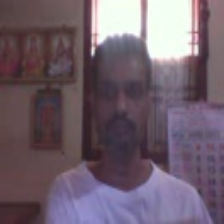

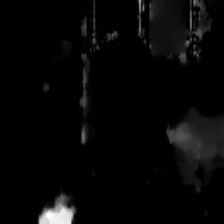

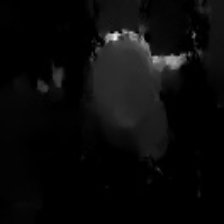

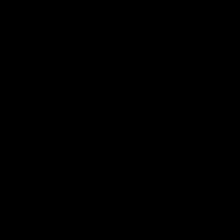

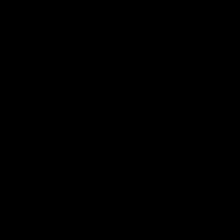

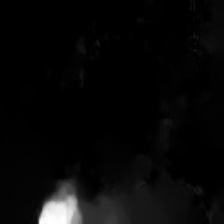

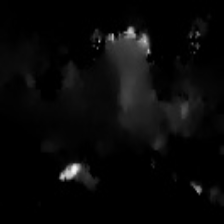

1
**********************************************************************
(224, 224, 3)


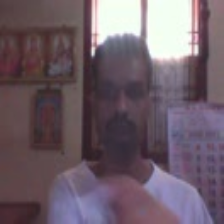

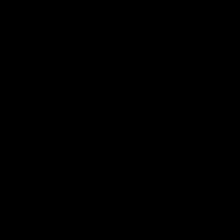

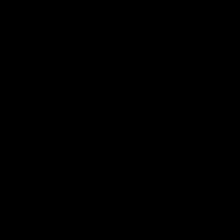

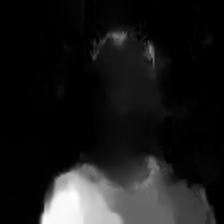

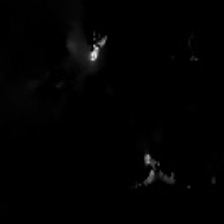

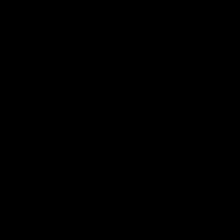

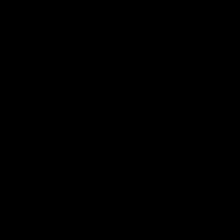

2
**********************************************************************
(224, 224, 3)


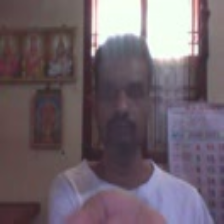

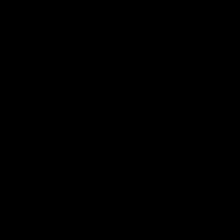

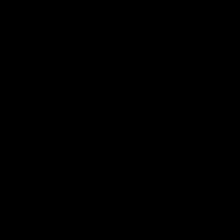

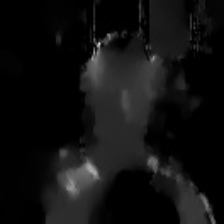

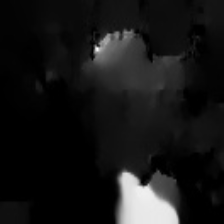

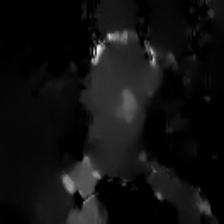

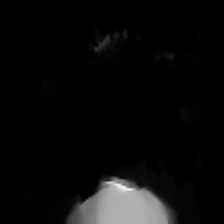

3
**********************************************************************
(224, 224, 3)


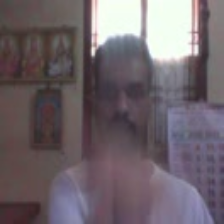

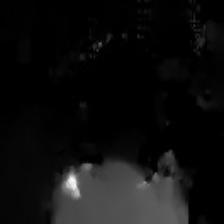

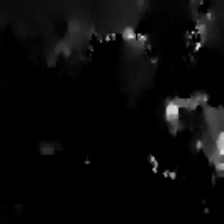

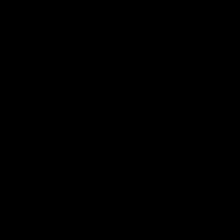

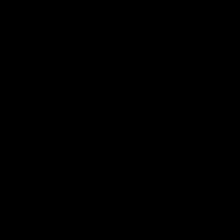

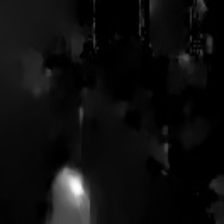

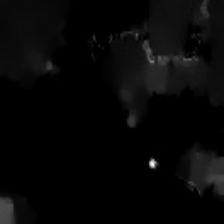

4
**********************************************************************
(224, 224, 3)


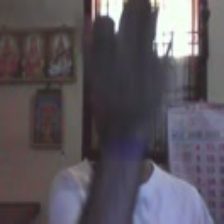

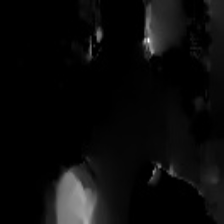

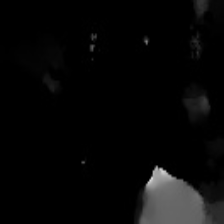

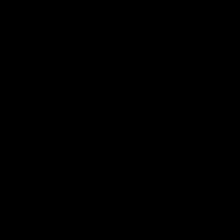

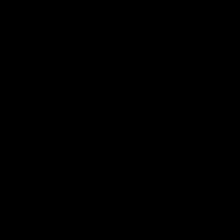

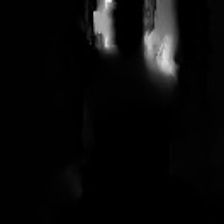

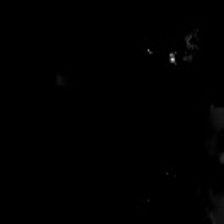

5
**********************************************************************
(224, 224, 3)


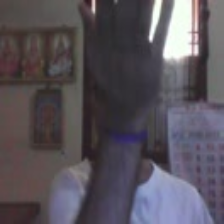

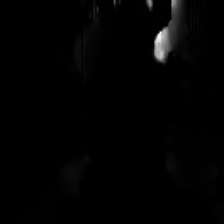

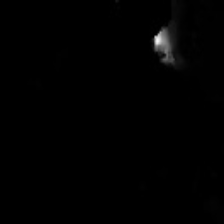

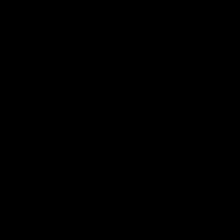

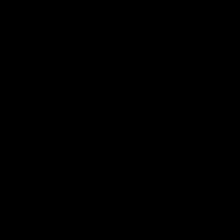

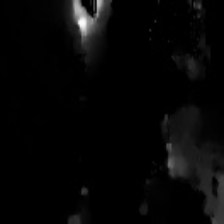

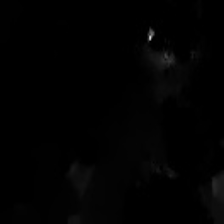

6
**********************************************************************
(224, 224, 3)


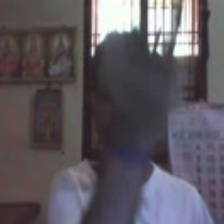

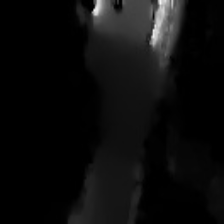

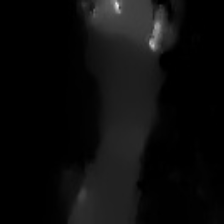

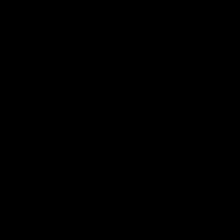

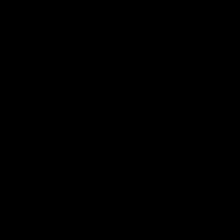

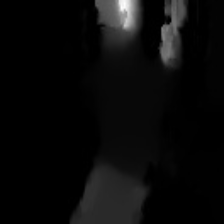

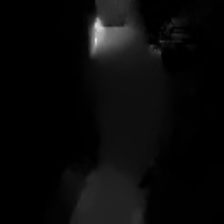

7
**********************************************************************
(224, 224, 3)


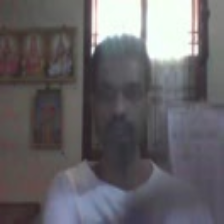

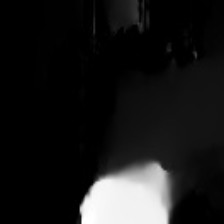

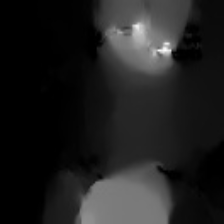

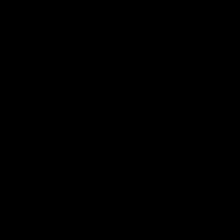

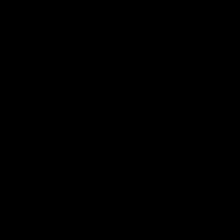

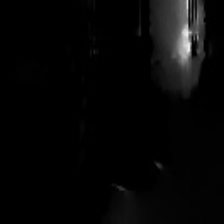

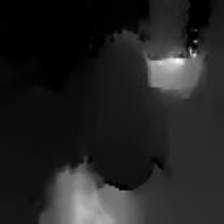

tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)




In [ ]:
for i in np.random.choice(len(train_image_paths), 1):
    print(i)
    r, f, label = extract_segments_and_label(train_image_paths[i])
    show_segments(r, f, label)
    print('=' * 70)
    print()
    print()

## Design Gesture Model

In [ ]:
num_projection_layers=1
projection_dims=512
flow_out_dims=512
dropout_rate=0.1
unresized_image_shape = (100, 176, 3)
unresized_flow_shape = (8, 100, 176, 6)
resized_flow_shape = (8, 224, 224, 6)
rgb_shape = (224, 224, 3)
fcn_input_shape = (8, (projection_dims + flow_out_dims))

In [ ]:
def project_embeddings_block(embeddings, num_projection_layers, projection_dims, dropout_rate):
    embeddings = layers.GlobalAvgPool2D()(embeddings)
    projected_embeddings = layers.Dense(units = projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [ ]:
def identity_block(inputs, filters):
    filters1, filters2, filters3 = filters
    bn_axis = 4
    
    x = layers.Conv3D(filters1, 3, padding='same')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.add([x, inputs])
    x = layers.Activation('relu')(x)
    
    return x

def conv_block(inputs, filters, strides = (1, 2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = 4
    
    x = layers.Conv3D(filters1, (1, 1, 1), strides = strides,
                      kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, (3, 3, 3), padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1),
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)

    shortcut = layers.Conv3D(filters3, (1, 1, 1), strides = strides,
                             kernel_initializer='he_normal')(inputs)
    shortcut = layers.BatchNormalization(axis=bn_axis)(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

# flow encoder takes --> a tensor of (batch_size, resized_flow_shape) as input
# and outputs --> a tensor of (batch_size, 8, 256)
def create_flow_encoder(resized_flow_shape):
    inputs = layers.Input(shape = resized_flow_shape, name = 'flow_encoder_input')   
    bn_axis = 4
    
    x = layers.Conv3D(64, (7, 7, 7),
                      strides=(1, 2, 2),
                      padding='same',
                      kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2))(x)

    x = conv_block(x, [64, 64, 256], strides=(1, 1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])
    
    x = conv_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024])
    x = conv_block(x, [256, 256, 512])
    x = conv_block(x, [256, 256, 512])
    x = conv_block(x, [512, 512, 512])
    # output_shape of (8, 2, 2, 256)
    x = layers.MaxPool3D((1, 2, 2))(x)
    x = layers.Reshape((8, 512))(x)
    return tf.keras.Model(inputs, x)


In [ ]:
def create_flow_model(flow_encoder, resized_flow_shape):
    # scrap reduce_channels concept
    inputs = layers.Input(shape = (resized_flow_shape), name = 'flow_input')
    embeddings = flow_encoder(inputs)
    return tf.keras.Model(inputs = inputs, outputs = embeddings, name = 'flow_model')

In [ ]:
def create_cnn_model(cnn_encoder, project_embeddings_block):
    rgb_batch = layers.Input(shape = rgb_shape)
    embeddings = cnn_encoder(rgb_batch)
    embeddings = project_embeddings_block(embeddings, num_projection_layers, projection_dims, dropout_rate)
    return tf.keras.Model(rgb_batch, embeddings, name = 'cnn_model')

In [ ]:
def create_fcn_model(fcn_input_shape, dropout_rate):
    """
    input : should be a fusion of all the embeddings created. 2 * 512 dimensional
    embeddings for each segment. 1 for rgb and 1 for the u, v flow images
    output : should be a softmax prediction 
    """
    
    inputs = layers.Input(shape = fcn_input_shape, name = 'fcn_input')
    x = layers.Flatten()(inputs)
    projected_embeddings = layers.Dense(units = 2048)(x)
    x = tf.nn.gelu(projected_embeddings)
    x = layers.Dense(2048, activation='gelu')(projected_embeddings)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Add()([projected_embeddings, x])
    x = layers.LayerNormalization()(x)
    x = layers.Dense(1024, activation='gelu')(x)
    pred = layers.Dense(5, activation='softmax')(x)

    return tf.keras.Model(inputs = inputs, outputs = pred, name = 'fcn_model')
    

In [ ]:
class Gesture_Model(tf.keras.Model):
    def __init__(self, cnn_model, flow_model, fcn_model, batch_size, **kwargs):
        super(Gesture_Model, self).__init__(**kwargs)
        
        #self.resize_and_rescale = resize_and_rescale
        self.cnn_model = cnn_model
        self.flow_model = flow_model 
        self.fcn_model = fcn_model

        self.loss_tracker = tf.keras.metrics.Mean(name = 'loss')
        self.accuracy_tracker = tf.keras.metrics.CategoricalAccuracy(name = 'accuracy')
        self.batch_size = batch_size
        
    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def call(self, segments, training = False):
        with tf.device("/gpu:0"):
            rgb_segments, flow_segments = segments
            batch_embeddings = []
            for i in range(self.batch_size):
                rgb_batch  = rgb_segments[i, :, :, :, :]
                embeddings = cnn_model(rgb_batch, training = training)   
                batch_embeddings.append(embeddings)

            rgb_embeddings = tf.stack(batch_embeddings)
            flow_encodings = flow_model(flow_segments, training = training)

            concat = tf.concat([rgb_embeddings, flow_encodings], axis = 2)

            pred = fcn_model(concat, training = training)

            return pred

    def compute_loss(self, y_true, pred):
        return tf.keras.losses.categorical_crossentropy(y_true, pred)

    def train_step(self, data):
        rgb_segments, flow_segments, y_true = data
        with tf.GradientTape() as tape:
            
            pred = self((rgb_segments, flow_segments), training = True)
            loss = self.compute_loss(y_true, pred)


        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y_true, pred)
        return {'loss' : self.loss_tracker.result(), 'accuracy' : self.accuracy_tracker.result()}

    def test_step(self, data):
        rgb_segments, flow_segments, y_true = data
        
        pred = self((rgb_segments, flow_segments), training = False)
        loss = self.compute_loss(y_true, pred)
        
        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(y_true, pred)
        return {'val_loss' : self.loss_tracker.result(), 'val_accuracy' : self.accuracy_tracker.result()}

## Create Gesture model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(rgb_shape[0], rgb_shape[1]),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
flow_encoder = create_flow_encoder(resized_flow_shape)
#flow_encoder.summary()

In [ ]:
flow_model = create_flow_model(flow_encoder, resized_flow_shape)
#flow_model.summary()

In [ ]:
cnn_encoder = tf.keras.applications.InceptionV3(include_top=False, input_shape=(rgb_shape[0], rgb_shape[1], 3))
cnn_encoder.trainable = True
cnn_output_shape = cnn_encoder.output_shape[1:]

In [ ]:
cnn_model = create_cnn_model(cnn_encoder, project_embeddings_block)
#cnn_model.summary()

In [ ]:
fcn_model = create_fcn_model(fcn_input_shape, dropout_rate)
#plot_model(fcn_model, show_shapes=True)
#fcn_model.summary()

In [ ]:
batch_size = 8

In [ ]:
gesture_model = Gesture_Model(cnn_model, flow_model, fcn_model, batch_size)

In [ ]:
gesture_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [ ]:
extra_train = len(train_image_paths) % batch_size
extra_val = len(val_image_paths) % batch_size
extra_train, extra_val

(6, 0)

In [ ]:
train_image_paths = shuffle(train_image_paths)
train_ds = tf.data.Dataset.from_tensor_slices(train_image_paths[:-extra_train])
train_ds = train_ds.map(extract_data)
train_ds = train_ds.shuffle(buffer_size=10)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(3)

In [ ]:
for x, y, z in train_ds:
    print(x.shape)
    print(y.shape)
    print(z.shape)
    pred = gesture_model.train_step((x, y, z))
    print(pred)
    break

(8, 8, 224, 224, 3)
(8, 8, 224, 224, 6)
(8, 5)
{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.3578794>, 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}


In [ ]:
for data in train_ds:
    print(data[0].shape)
    #print(data[1])
    pred = gesture_model.test_step(data)
    print(pred)
    break

(8, 8, 224, 224, 3)
{'val_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.3421097>, 'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.25>}


In [ ]:
gesture_model.summary()

Model: "gesture__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_model (Functional)       (None, 512)               23115552  
_________________________________________________________________
flow_model (Functional)      (None, 8, 512)            26496064  
_________________________________________________________________
fcn_model (Functional)       (None, 5)                 23083013  
Total params: 72,694,633
Trainable params: 72,636,261
Non-trainable params: 58,372
_________________________________________________________________


##Training Model

In [ ]:
batch_size = 4

In [ ]:
extra_train = len(train_image_paths) % batch_size
extra_val = len(val_image_paths) % batch_size
extra_train, extra_val

(2, 0)

In [ ]:
train_image_paths = shuffle(train_image_paths)
train_ds = tf.data.Dataset.from_tensor_slices(train_image_paths[:-extra_train])
#train_ds = tf.data.Dataset.from_tensor_slices(train_image_paths[:1000])
train_ds = train_ds.map(extract_data)
train_ds = train_ds.shuffle(buffer_size=10)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(3)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
val_image_paths = shuffle(val_image_paths)
val_ds = tf.data.Dataset.from_tensor_slices(val_image_paths[:-extra_val])
#val_ds = tf.data.Dataset.from_tensor_slices(val_image_paths[:1000])
val_ds = val_ds.map(extract_data)
val_ds = val_ds.shuffle(buffer_size=10)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(3) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
for x, y, z in train_ds:
    print(x.shape)
    print(y.shape)
    print(z.shape)
    #show_segments(x[0].numpy(), y[0].numpy(), z[0].numpy())
    break

(4, 8, 224, 224, 3)
(4, 8, 224, 224, 6)
(4, 5)


In [ ]:
num_epochs = 5

flow_encoder = create_flow_encoder(resized_flow_shape)
flow_model = create_flow_model(flow_encoder, resized_flow_shape)

cnn_encoder = tf.keras.applications.InceptionV3(include_top=False, input_shape=(rgb_shape[0], rgb_shape[1], 3))
cnn_encoder.trainable = True
cnn_output_shape = cnn_encoder.output_shape[1:]
cnn_model = create_cnn_model(cnn_encoder, project_embeddings_block)

fcn_model = create_fcn_model(fcn_input_shape, dropout_rate)

gesture_model = Gesture_Model(cnn_model, flow_model, fcn_model, batch_size)

gesture_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001),
    metrics = ['accuracy']
)

In [ ]:
for x, y, z in train_ds:
    print(x.shape)
    print(y.shape)
    print(z.shape)
    pred = gesture_model((x, y))
    print(pred)
    break

(4, 8, 224, 224, 3)
(4, 8, 224, 224, 6)
(4, 5)
tf.Tensor(
[[0.15690054 0.06241569 0.0093752  0.5920481  0.17926042]
 [0.11147721 0.05929382 0.05143951 0.517791   0.2599985 ]
 [0.10330176 0.02459412 0.05093921 0.52342236 0.29774255]
 [0.07317267 0.09467982 0.02723831 0.43744376 0.36746547]], shape=(4, 5), dtype=float32)


In [ ]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of Videos): {len(train_ds) * batch_size}")
print(f"Batch size: {batch_size}")

# Create a learning rate scheduler callback.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, verbose = 1
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF_Models/Gesture_model_v3.h5',
     monitor = 'val_loss', verbose = 1, save_weights_only = True, save_best_only = True
)

tf.config.run_functions_eagerly(True)
history = gesture_model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
)

Number of GPUs: 1
Number of Videos): 21060
Batch size: 4
Epoch 1/5
5265/5265 [==============================] - 10543s 2s/step - loss: 1.3014 - accuracy: 0.4501
Epoch 2/5
5265/5265 [==============================] - 10514s 2s/step - loss: 1.2231 - accuracy: 0.5028
Epoch 3/5
3954/5265 [=====================>........] - ETA: 42:34 - loss: 1.2171 - accuracy: 0.5090

KeyboardInterrupt: ignored

In [ ]:
gesture_model.save_weights('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/MFF_Models/Gesture_model_v4.h5')

### plotting history

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
 plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
accuracy = tf.keras.metrics.CategoricalAccuracy()
for data in val_ds:
    pred = Gesture_model(data[0])
    accuracy.update_state(data[1], pred)
accuracy.result().numpy()
    

In [ ]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state([0, 0, 1], [0.1, 0.5, 0.51])
m.result().numpy()

In [ ]:
Gesture_model.evaluate(data[0], data[1])